In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
%matplotlib inline
torch.manual_seed(0)
sns.set()

In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

In [4]:
df = pd.read_csv('data_series.csv')

In [5]:
all_data = df.values.astype(float)

In [6]:
test_data_size = int(all_data.shape[0]/13)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [7]:
scaler = RobustScaler(quantile_range=(25, 75))
# scaler = MinMaxScaler(feature_range=(0, 7))
train_data_normalized = scaler.fit_transform(train_data)

In [8]:
train_window = test_data_size
train_data_normalized = torch.FloatTensor(train_data_normalized)

In [9]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [10]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [11]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.num_layers = num_layers
        
        self.hidden_cell = torch.zeros(num_layers, 1, self.hidden_layer_size)
        
        self.gru = nn.GRU(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)
                
    def forward(self, input_seq):
        gru_out, self.hidden_cell = self.gru(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(gru_out.view(len(input_seq), -1))
        return predictions[-1].view(1, -1)

In [12]:
model = GRU(10463, 3000, 10463, num_layers=4)
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
print(model)

GRU(
  (gru): GRU(10463, 3000, num_layers=4)
  (linear): Linear(in_features=3000, out_features=10463, bias=True)
)


In [14]:
# Erase gradient from previous trainings
model.zero_grad()

In [29]:
epochs = 400

pbar = tqdm(np.arange(1, epochs+1), desc = 'train loop')
for e in pbar:
    for i, (seq, labels) in enumerate(train_inout_seq):
        optimizer.zero_grad()
        
        model.hidden_cell = torch.zeros(4, 1, 3000)
        
        y_pred = model(seq)
        
        sample_weight = torch.Tensor(train_data[i])

        loss = criterion(y_pred, labels)
        loss = (loss * sample_weight / sample_weight.sum())
        loss = loss.sum()
        
        loss.backward()
        optimizer.step()
        
    if e%15 == 1:
        print(f'epoch: {e:3} loss: {loss.item():10.8f}')

print(f'epoch: {e:3} loss: {loss.item():10.10f}', '\n')
print('Your model has finished training!')

train loop:   0%|          | 1/400 [00:37<4:09:56, 37.59s/it]

epoch:   1 loss: 1137.82983398


train loop:   4%|▍         | 16/400 [09:54<3:58:23, 37.25s/it]

epoch:  16 loss: 666.85162354


train loop:   8%|▊         | 31/400 [19:36<3:54:03, 38.06s/it]

epoch:  31 loss: 432.21685791


train loop:  12%|█▏        | 46/400 [29:34<3:58:36, 40.44s/it]

epoch:  46 loss: 289.71640015


train loop:  15%|█▌        | 61/400 [39:36<3:45:16, 39.87s/it]

epoch:  61 loss: 190.87011719


train loop:  19%|█▉        | 76/400 [49:35<3:37:16, 40.23s/it]

epoch:  76 loss: 126.86897278


train loop:  23%|██▎       | 91/400 [59:39<3:29:03, 40.59s/it]

epoch:  91 loss: 84.64134216


train loop:  26%|██▋       | 106/400 [1:09:41<3:16:55, 40.19s/it]

epoch: 106 loss: 57.76977921


train loop:  30%|███       | 121/400 [1:21:18<3:20:52, 43.20s/it]

epoch: 121 loss: 40.19356537


train loop:  34%|███▍      | 136/400 [1:31:12<2:52:35, 39.22s/it]

epoch: 136 loss: 35.83543396


train loop:  38%|███▊      | 151/400 [1:41:04<2:46:43, 40.18s/it]

epoch: 151 loss: 25.22204208


train loop:  42%|████▏     | 166/400 [1:50:51<2:32:37, 39.13s/it]

epoch: 166 loss: 22.02991104


train loop:  45%|████▌     | 181/400 [2:00:39<2:22:51, 39.14s/it]

epoch: 181 loss: 25.06384087


train loop:  49%|████▉     | 196/400 [2:56:56<2:34:04, 45.32s/it]  

epoch: 196 loss: 19.66594124


train loop:  49%|████▉     | 197/400 [2:57:53<3:03:18, 54.18s/it]


KeyboardInterrupt: 

## Forecasting

In [30]:
fut_pred = train_window

test_inputs = train_data_normalized[-train_window:].tolist()

In [31]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq))

In [32]:
test_inputs[fut_pred:]

[tensor([[-4.6522e-03, -2.1918e-01, -6.0080e+00,  ..., -7.6356e-01,
           9.8455e-01, -8.1992e-01]])]

In [33]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[0]).reshape(1, -1))
actual_predictions = np.array(actual_predictions, dtype=int)
actual_predictions

array([[0, 0, 1, ..., 0, 0, 0]])

In [34]:
test_data = test_data.reshape(-1)
actual_predictions = actual_predictions.reshape(-1)

In [35]:
hack = np.random.randint(100, size=10463)
hack = test_data + hack

print(hack)

[ 91.  96. 217. ...  11.  32.   4.]


In [36]:
hack_old = hack.copy()

for i in np.arange(10463):
    if test_data[i] == 0:
        hack[i] = 0
        
print(hack)

[ 91.   0. 217. ...   0.   0.   0.]


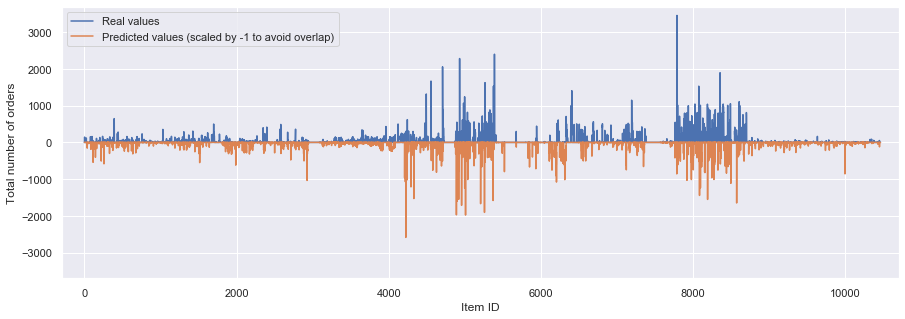

In [37]:
x = np.arange(10463)

plt.ylabel('Total number of orders')
plt.xlabel('Item ID')
plt.grid(True)
plt.ylim(-3700, 3700)
plt.xlim(-300, 10700)
plt.plot(x, test_data, label='Real values')
plt.plot(x, -actual_predictions, label='Predicted values (scaled by -1 to avoid overlap)')
plt.legend()
plt.show()

In [38]:
sim_price = pd.read_csv('sim_price.csv')

In [39]:
sim_price.head()

,simulationPrice
0,3.43
1,9.15
2,14.04
3,14.10
4,7.48


In [40]:
def earnings(targets, predictions, simulatedPrices):
    temp = (predictions - np.maximum(predictions - targets, 0) * 1.6)
    return np.sum(temp*simulatedPrices)

In [41]:
sim_price = sim_price.values.reshape(-1)

In [42]:
earnings(test_data, hack, sim_price)

-2575926.058000001